# data availability and states + Prompt Generation

date format in this notebook is yyyy-mm-dd

In [1]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import pickle 
import random
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
from dateutil.relativedelta import relativedelta
from datetime import datetime
from datetime import datetime, timedelta
from sklearn.mixture import GaussianMixture

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from utils.evaluate import evaluate, r4
from utils.openai import OpenAIEmbedding
from utils.utils import human_format_number, human_format_number2
from utils.companies import company100_name, company100_name_shorten, company100_ticker, Company_desc100

OAE = OpenAIEmbedding()

In [3]:
from DataProcessor.historic import get_target, get_momentums, historic_moving_average_6m
from DataProcessor.historic import historic_vol_moving_average_6m, historic_6m, historic_moving_std_6m

In [4]:
from DataProcessor.news import historic_news, clean_news

In [5]:
from DataProcessor.financials import financials_nq

In [6]:
from openai import OpenAI
client = OpenAI(api_key='YOUR_API_KEY')


In [7]:
start_date = '2015-01-01'
end_date = '2024-01-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
formatted_dates = date_range.strftime('%Y-%m-%d').tolist()

## Directories

In [8]:
dataset_path = '../dataset/'
historic_data_path = '../dataset/Historical Price/'
financials_data_path = '../dataset/Financial Quarterly Reports/'
news_data_path = '../dataset/News Articles/'
news_wsj_path = '../dataset/News Articles/WSJ-Header/'
news_nyt_path = '../dataset/News Articles/NYT/110/'
news_alphav_path = '../dataset/News Articles/Alpha-V/without text 104/'
news_CMINUS_path = '../dataset/News Articles/CMIN-US/'
news_path = '../dataset/News Articles/embedded/'
dotcsv = '.csv'

In [9]:
def get_dir_list(path):
    listt = os.listdir(path)
    if '.DS_Store' in listt:
        listt.remove('.DS_Store')
    if '.ipynb_checkpoints' in listt:
        listt.remove('.ipynb_checkpoints')
    return listt

# News Summerizer

In [11]:
prompt_template = """You are processing news headlines and abstracts to extract meaningful information \
in sentence form, with each sentence capturing key details. Provide up to 4 \
short bullet points, summarizing important aspects such as a company's performance, \
stock market activity, new products, important personnel, and relevant news about competitors or rival companies. \
For example:\nThe company launched a new product.\nThe CEO of the company passed away.\n\
The industry is experiencing a recession.\nA rival company is performing well.
Market analysts recommend not investing in the company.\n\nNews about company {ticker}:\n{text}"""

prompt_template = """you are processing news headline and the abstract to extract \
meaningful information in bullet point format. There can be up to 4 bullet point summaries.\
each bullet point should include few words.\
The summaries should be informative about a company's performance generally or in stock market, \
new products, people working at the company, news about the rival companies etc.

for example:
company new product X
company CEO died
company's industry in recession 
company's rival performing good
market analysts say don't invest
company's rival product release x
company's product x discontinued


News for company {ticker} ({text})::\n"""

def get_name(ticker):
    for i in range(len(company100_ticker)):
        if ticker == company100_ticker[i]:
            return company100_name[i]
    return "Company X"

def find_best_gmm_n_clusters(embeddings, force_two=False):
    bic_values = []
    
    n_components_range = range(1, int(len(embeddings)/10)+2)
    if len(embeddings) < 20: n_components_range = [1,2]
    if force_two:
        n_components_range = range(2, int(len(embeddings)/10)+1)
        if len(embeddings) < 20: n_components_range = [2,3]
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(embeddings)
        bic_values.append(gmm.bic(embeddings))
    optimal_n_clusters_bic = n_components_range[np.argmin(bic_values)]
    return optimal_n_clusters_bic

def summarize_text(model, text, prompt, ticker):
    ticker = get_name(ticker)
    try:
        prompt = prompt
        prompt = prompt.format(ticker=ticker, text=text)
        
        if model == "gpt-3.5-turbo":
            completion = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt},
                ]
            )
            summary = completion.choices[0].message.content.strip()

        elif model == "gpt-3.5-turbo-instruct":
            response = client.completions.create(
                model=model,
                prompt=prompt,
                max_tokens=50,
            )
            summary = response.choices[0].text.strip()

        else:
            raise ValueError("Unsupported model specified.")
        return summary
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return None

def summarize_news(news_data, ticker, model, max_words=2500, parent_cluster=None, cluster_level=0, force_two=False):
    all_summaries = ""
    embeddings = np.array([np.array(embedding) for embedding in news_data['Embedding'].values()])
    optimal_n_clusters = find_best_gmm_n_clusters(embeddings, force_two)
    gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=0)
    gmm_labels = gmm.fit_predict(embeddings)
    keys = list(news_data['Embedding'].keys())
    cluster_labels = {key: label for key, label in zip(keys, gmm_labels)}
    
    news_data['Cluster'] = cluster_labels
    clusters = sorted(set(gmm_labels))
    # print('hii', len(news_data['Embedding']), clusters)
    # print(cluster_labels)
    for cluster in clusters:
        cluster_keys = [key for key, label in cluster_labels.items() if label == cluster]
        cluster_news = set(news_data['Combined'][key] for key in cluster_keys)
        news = '\n'.join(f"{item}" for item in cluster_news)
        if news:
            words_per_cluster = news.split()
            if len(words_per_cluster) > max_words:
                subcluster_news_data = {
                    'Embedding': {key: news_data['Embedding'][key] for key in cluster_keys},
                    'Combined': {key: news_data['Combined'][key] for key in cluster_keys}
                }
                subcluster_summary, updated_subcluster_data = summarize_news(
                    subcluster_news_data, ticker, model, max_words, parent_cluster=cluster, cluster_level=cluster_level + 1, force_two=True
                )

                #news_data['Cluster'].update(updated_subcluster_data['Cluster'])
                all_summaries += subcluster_summary
            else:
                summary = summarize_text(model, news, prompt_template, ticker)
                if summary:
                    all_summaries += summary + "\n"
    return all_summaries, news_data

# Create Prompts Data Loader

In [12]:
def process_historic(ticker, qdate, include_volume = 0.0):
    try:
        ma = ", ".join(r4(historic_moving_average_6m(ticker, qdate)))
        
        nancount = ma.count('nan')
        if nancount > 1:
            return (-1, "too many missing data in historic data")
        moving_average_temp = """Moving average for monthly price data for past 6 moths: $ma$"""
        res = moving_average_temp.replace('$ma$', ma)
        if np.random.rand() >= include_volume:
            formatted_numbers = [human_format_number2(num) for num in historic_vol_moving_average_6m(ticker, qdate)]
            va = ", ".join(formatted_numbers)
            moving_volume_temp = """Average volume of exchange for last 6 monts from old to new: $va$"""
            moving_volume_temp = moving_volume_temp.replace('$va$', va)
            res = res + '\n' + moving_volume_temp
    except Exception as e:
        return (-1, e)
    return (1, str('historic price data:\n'+res))

def process_financials(ticker, qdate):
    try:
        res = 'Financial data for last four quarters from old to new:\n'
        fins = financials_nq(ticker, qdate, 4)

        dates = 'dates:\t' + '\t'.join([str(i).split()[0] for i in fins['date']]) + '\n'
        res+= dates
        wanted_features = ['total revenue',  'net income', 'total assets', \
                           'averageMarketPrice', 'earning per share', 'free cash flow', \
                            'quarterly EPS growth', 'cashflow to assets', 'operating margin']
        keys = list(fins.keys())[1:]

        if len(keys) <= 10:
            return (-1, "Too many missing Values in financials")
        sampled_dict = {key: fins[key] for key in keys if key in wanted_features}

        a = [kl + ':\t' + "\t"
                .join([str(human_format_number2(num)) for num in sampled_dict[kl]]) for kl in sampled_dict]
        for i in a:
            if len(i) < 30:
                return (-1, 'not enough data')
            if i.count('nan') > 2:
                return (-1, "Too many missing data")
    except Exception as e:
        return (-1, e)
    res = res+'\n'.join(a)
    res = res.replace('averageMarketPrice', 'average market price')
    return (1, res)

def process_news(ticker, qdate, model):
    try: 
        path = news_path + ticker + dotcsv
        news = historic_news(path, ticker, qdate, '1m')
        news = clean_news(news)
        if len(news) < 20:
            news = historic_news(path, ticker, qdate, '3m')
        news = clean_news(news)
        if len(news)<2:
            return (-1, "not enough news data")
    except Exception as e:
        return (-1, "loading news from file:" + str(e))
    # try:
    news_data = {"Combined": {}, "Embedding": {}}
    for i, item in enumerate(news):
        news_data["Combined"][i] = str(item["headline"]) + " " + str(item["abstract"])
        news_data["Embedding"][i] = ast.literal_eval(item["embedding"])
    summary, _ = summarize_news(news_data, ticker, model, max_words=3000)
    # print(_)
    # except Exception as e:
        # return (-1, "summarizer:" + str(e))
    return (1, "News Summaries:\n"+ summary)

# Promp Generation

In [13]:
start_from = 53
for coounter, ticker in enumerate(company100_ticker[start_from:start_from+7]):
    print(coounter+start_from, ticker)
    prompts = []
    
    for qdate in tqdm(formatted_dates[1:]):
        status_t, targets_bin = get_target(ticker, qdate, binn = True)
        status_b, target = get_target(ticker, qdate, binn = False)
        if status_t + status_b <= 0 : 
            print('error-get_target', ticker, qdate, target)
            continue
        status_h, historic = process_historic(ticker, qdate, 1)
        if status_h == -1:
            print('error-process_historic', ticker, qdate, historic)
            historic = ''
        status_f, financials = process_financials(ticker, qdate)
        if status_f == -1:
            print('error-process_financials', ticker, qdate, financials)
            financials = ''
        if status_t + status_b < 0 : 
            continue

        status_n, news_summaries = process_news(ticker, qdate, model = "gpt-3.5-turbo")
        if status_n == -1:
            print('error-process_news', ticker, qdate, news_summaries)
            continue
        comp_disc = Company_desc100[ticker]

        datum = {'prompt': comp_disc + '\n' + news_summaries +\
                '\n' + financials + '\n' + historic,
                  'ticker': ticker,
                  'targets': target,
                  'targets_bin': targets_bin,
                  'date': qdate}
        prompts.append(datum)
    print(len(prompts), "prompts generated for", ticker)
    with open('./prompts/full/' + ticker + '.pkl', 'wb') as file:  
        pickle.dump(prompts, file)

100%|██████████| 108/108 [13:37<00:00,  7.57s/it]


108 prompts generated for T
55 VZ


100%|██████████| 108/108 [09:17<00:00,  5.16s/it]


108 prompts generated for VZ
56 AMT


  1%|          | 1/108 [00:00<00:27,  3.83it/s]

error-process_news AMT 2015-02-01 not enough news data


  2%|▏         | 2/108 [00:00<00:25,  4.13it/s]

error-process_news AMT 2015-03-01 not enough news data


  5%|▍         | 5/108 [00:02<01:04,  1.61it/s]

error-process_news AMT 2015-06-01 not enough news data


  6%|▌         | 6/108 [00:03<00:49,  2.07it/s]

error-process_news AMT 2015-07-01 not enough news data


  6%|▋         | 7/108 [00:03<00:39,  2.53it/s]

error-process_news AMT 2015-08-01 not enough news data


  7%|▋         | 8/108 [00:03<00:33,  2.97it/s]

error-process_news AMT 2015-09-01 not enough news data


  8%|▊         | 9/108 [00:03<00:29,  3.31it/s]

error-process_news AMT 2015-10-01 not enough news data


  9%|▉         | 10/108 [00:04<00:27,  3.61it/s]

error-process_news AMT 2015-11-01 not enough news data


 10%|█         | 11/108 [00:04<00:25,  3.87it/s]

error-process_news AMT 2015-12-01 not enough news data


 11%|█         | 12/108 [00:04<00:23,  4.08it/s]

error-process_news AMT 2016-01-01 not enough news data


 12%|█▏        | 13/108 [00:04<00:22,  4.21it/s]

error-process_news AMT 2016-02-01 not enough news data


 13%|█▎        | 14/108 [00:04<00:21,  4.34it/s]

error-process_news AMT 2016-03-01 not enough news data


 14%|█▍        | 15/108 [00:05<00:20,  4.45it/s]

error-process_news AMT 2016-04-01 not enough news data


 15%|█▍        | 16/108 [00:05<00:20,  4.52it/s]

error-process_news AMT 2016-05-01 not enough news data


 16%|█▌        | 17/108 [00:05<00:19,  4.58it/s]

error-process_news AMT 2016-06-01 not enough news data


 17%|█▋        | 18/108 [00:05<00:19,  4.62it/s]

error-process_news AMT 2016-07-01 not enough news data


 18%|█▊        | 19/108 [00:06<00:20,  4.37it/s]

error-process_news AMT 2016-08-01 not enough news data


 19%|█▊        | 20/108 [00:06<00:19,  4.48it/s]

error-process_news AMT 2016-09-01 not enough news data


 19%|█▉        | 21/108 [00:06<00:19,  4.55it/s]

error-process_news AMT 2016-10-01 not enough news data


 20%|██        | 22/108 [00:06<00:18,  4.54it/s]

error-process_news AMT 2016-11-01 not enough news data


 21%|██▏       | 23/108 [00:06<00:18,  4.59it/s]

error-process_news AMT 2016-12-01 not enough news data


 22%|██▏       | 24/108 [00:07<00:18,  4.62it/s]

error-process_news AMT 2017-01-01 not enough news data


 23%|██▎       | 25/108 [00:07<00:17,  4.64it/s]

error-process_news AMT 2017-02-01 not enough news data


 24%|██▍       | 26/108 [00:07<00:17,  4.68it/s]

error-process_news AMT 2017-03-01 not enough news data


 25%|██▌       | 27/108 [00:07<00:17,  4.69it/s]

error-process_news AMT 2017-04-01 not enough news data


 26%|██▌       | 28/108 [00:07<00:17,  4.70it/s]

error-process_news AMT 2017-05-01 not enough news data


 27%|██▋       | 29/108 [00:08<00:16,  4.69it/s]

error-process_news AMT 2017-06-01 not enough news data


 28%|██▊       | 30/108 [00:08<00:16,  4.69it/s]

error-process_news AMT 2017-07-01 not enough news data


 29%|██▊       | 31/108 [00:08<00:16,  4.69it/s]

error-process_news AMT 2017-08-01 not enough news data


 30%|██▉       | 32/108 [00:08<00:16,  4.65it/s]

error-process_news AMT 2017-09-01 not enough news data


 31%|███       | 33/108 [00:08<00:16,  4.65it/s]

error-process_news AMT 2017-10-01 not enough news data


 31%|███▏      | 34/108 [00:09<00:16,  4.37it/s]

error-process_news AMT 2017-11-01 not enough news data


 32%|███▏      | 35/108 [00:09<00:16,  4.48it/s]

error-process_news AMT 2017-12-01 not enough news data


 33%|███▎      | 36/108 [00:09<00:15,  4.55it/s]

error-process_news AMT 2018-01-01 not enough news data


100%|██████████| 108/108 [03:15<00:00,  1.81s/it]


74 prompts generated for AMT
57 CAT


100%|██████████| 108/108 [05:12<00:00,  2.89s/it]


108 prompts generated for CAT
58 DLR


  1%|          | 1/108 [00:00<00:14,  7.50it/s]

error-process_news DLR 2015-02-01 not enough news data


  3%|▎         | 3/108 [00:00<00:11,  9.46it/s]

error-process_news DLR 2015-03-01 not enough news data
error-process_news DLR 2015-04-01 not enough news data
error-process_news DLR 2015-05-01 not enough news data


  5%|▍         | 5/108 [00:00<00:10,  9.93it/s]

error-process_news DLR 2015-06-01 not enough news data
error-process_news DLR 2015-07-01 not enough news data


  6%|▋         | 7/108 [00:00<00:09, 10.11it/s]

error-process_news DLR 2015-08-01 not enough news data


  8%|▊         | 9/108 [00:00<00:09, 10.23it/s]

error-process_news DLR 2015-09-01 not enough news data
error-process_news DLR 2015-10-01 not enough news data
error-process_news DLR 2015-11-01 not enough news data


 10%|█         | 11/108 [00:01<00:09, 10.23it/s]

error-process_news DLR 2015-12-01 not enough news data
error-process_news DLR 2016-01-01 not enough news data


 12%|█▏        | 13/108 [00:01<00:09, 10.32it/s]

error-process_news DLR 2016-02-01 not enough news data


 14%|█▍        | 15/108 [00:01<00:08, 10.38it/s]

error-process_news DLR 2016-03-01 not enough news data
error-process_news DLR 2016-04-01 not enough news data
error-process_news DLR 2016-05-01 not enough news data


 16%|█▌        | 17/108 [00:01<00:08, 10.30it/s]

error-process_news DLR 2016-06-01 not enough news data
error-process_news DLR 2016-07-01 not enough news data


 18%|█▊        | 19/108 [00:01<00:08, 10.32it/s]

error-process_news DLR 2016-08-01 not enough news data
error-process_news DLR 2016-09-01 not enough news data
error-process_news DLR 2016-10-01 not enough news data


 21%|██▏       | 23/108 [00:02<00:08, 10.05it/s]

error-process_news DLR 2016-11-01 not enough news data
error-process_news DLR 2016-12-01 not enough news data
error-process_news DLR 2017-01-01 not enough news data


 25%|██▌       | 27/108 [00:02<00:08,  9.80it/s]

error-process_news DLR 2017-02-01 not enough news data
error-process_news DLR 2017-03-01 not enough news data
error-process_news DLR 2017-04-01 not enough news data


 27%|██▋       | 29/108 [00:02<00:07, 10.00it/s]

error-process_news DLR 2017-05-01 not enough news data
error-process_news DLR 2017-06-01 not enough news data
error-process_news DLR 2017-07-01 not enough news data


 32%|███▏      | 35/108 [00:05<00:16,  4.37it/s]

error-process_news DLR 2017-10-01 not enough news data
error-process_news DLR 2017-11-01 not enough news data
error-process_news DLR 2017-12-01 not enough news data
error-process_news DLR 2018-01-01 not enough news data


100%|██████████| 108/108 [01:52<00:00,  1.04s/it]


74 prompts generated for DLR
59 JD


 36%|███▌      | 39/108 [01:12<04:28,  3.89s/it]

In [16]:
with open('./prompts/full/' + 'AAPL' + '.pkl', 'rb') as file:  
    ddd = pickle.load(file)
print(ddd[0]['prompt'])
ddd[0]

Apple Inc. designs, manufactures, and sells consumer electronics, software, and services, operating in the technology industry.
News Summaries:
- Tesla CEO Elon Musk halts Model Y production to avoid "production hell" experienced with Model 3
- Apple supplier Foxconn reports 15% profit drop due to slower growth in iPhone shipments
- Warren Buffett's Berkshire Hathaway prepares for future without him, with new vice chairmen overseeing business units
- Fidelity employees fired for alleged misuse of reimbursement programs, including fraudulent purchases and cancellations with company reimbursement
- Amazon discloses that over a million U.S. small businesses sell on its site
- Apple announces a $100 billion buyback plan for its stock
- Apple collaborates with Goldman Sachs on a new credit card under the Apple Pay brand
- Amazon's facial recognition technology raises civil rights concerns

Financial data for last four quarters from old to new:
dates:	2017-06-30	2017-09-30	2017-12-31	2018-03

# Check Data Availability

### News Data

In [8]:
start_date = '2015-01-01'
end_date = '2024-01-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
formatted_dates = date_range.strftime('%Y-%m-%d').tolist()

In [17]:
def r44(value):
    return f"{round(value, 3):.3f}"
def get_all_news(date, ticker, time_line):
    try:
        a = len(historic_news_wsj(ticker, date, time_line))
    except:
        a = 0
    try:
        b = len(historic_news_nyt(ticker, date, time_line))
    except:
        b = 0
    try:
        c = len(historic_news_cmin(ticker, date, time_line))
    except:
        c = 0
    try:
        d = len(historic_news_alphav(ticker, date, time_line))
    except:
        d = 0
    
    return a+b+c+d


In [10]:
import contextlib
import sys

period = '1m'
results = []
for i in tqdm(formatted_dates):
    for ticker, name in zip(company100_ticker,company100_name_shorten):
        with contextlib.redirect_stdout(None):
            n = get_all_news(i, ticker, period)
            results.append(n)

100%|██████████| 109/109 [16:59<00:00,  9.35s/it]


In [11]:
period = '3m'
results3 = []
for i in tqdm(formatted_dates):
    for ticker, name in zip(company100_ticker,company100_name_shorten):
        with contextlib.redirect_stdout(None):
            n = get_all_news(i, ticker, period)
            results3.append(n)

100%|██████████| 109/109 [16:43<00:00,  9.21s/it]


In [12]:
results[0]

1

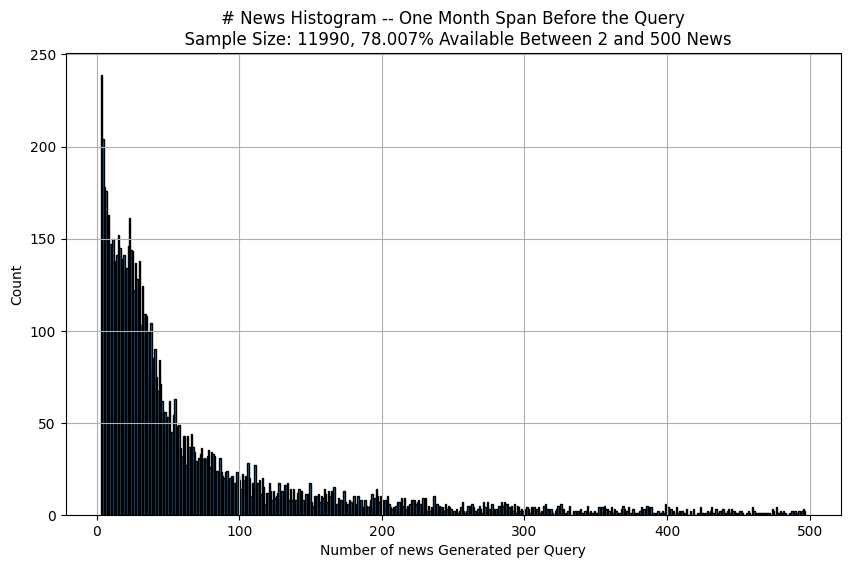

In [32]:
import matplotlib.pyplot as plt

def create_histogram(data, bins=10, title='Histogram', xlabel='', ylabel='Frequency'):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig('./hist1.png', dpi = 300)

data = [i for i in results if i < 500 and i > 2]
percent = r44(len(data)/len(results)*100)
create_histogram(data, bins=500, 
                 title='# News Histogram -- One Month Span Before the Query\n \
                 Sample Size: ' + str(len(results)) + ', ' + percent + '% Available Between 2 and 500 News                ', 
                 xlabel='Number of news Generated per Query', ylabel='Count')


### Financials

In [17]:
for ticker, name in zip(company100_ticker,company100_name_shorten):
    try:
        a = get_target(ticker, '2020-01-01', binn = False)
        a = get_momentums(ticker, '2020-01-01', binn = False)
        a = historic_moving_average_6m(ticker, '2020-01-01')
        a = historic_moving_std_6m(ticker, '2020-01-01')
        a = historic_vol_moving_average_6m(ticker, '2020-01-01')
        a = historic_6m(ticker, '2020-01-01')
    except:
        print('no data for:', ticker, name)

11990

In [ ]:
all_news_count = []
for ticker, name in zip(company100_ticker,company100_name_shorten):
    try:
        a = 100 #historic_news_wsj(ticker, '2024-06-31', '120m')
    except:
        print('no wsj data for:', ticker, name)
    try:
        b = len(historic_news_nyt(ticker, '2024-06-30', '120m'))
    except:
        print('no nyt data for:', ticker, name)
    try:
        c = len(historic_news_cmin(ticker, '2024-06-30', '120m'))
    except:
        print('no cmin data for:', ticker, name)
    try:
        d = len(historic_news_alphav(ticker, '2024-06-30', '120m'))
    except:
        print('no alphav data for:', ticker, name)
    all_news_count.append(d)
print('total of', sum(all_news_count), 'articles.')

### Financials

In [10]:
for ticker, name in zip(company100_ticker,company100_name_shorten):
    try:
        a = financials_nq(ticker, '2024-12-01', 40)
    except:
        print('no data for:', ticker, name)


no data for: FB facebook
no data for: BBL BHP
no data for: SNPMF China Petroleum
no data for: SPG Simon Property
no data for: C Citigroup
no data for: PTR PetroChina
no data for: RDS-B Royal Dutch
no data for: WFC Wells Fargo
